In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk
import pickle as pkl

import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the
# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import Qmake_encoder_set_weights, Qmake_decoder_set_weights, Qmake_discriminator, VAE_GAN_Model
from data_and_eval_utils import load_preprocessed_snl, plot_rocs, calc_anomaly_dist, AD_score_KL, AD_score_CKL
# from models import VAE_Model_ATLAS_beta as NNmodel


# # Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(gpus[3], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
SAVE_PATH = home_path+f"/GAN_trainings/" 

### Loss plots.

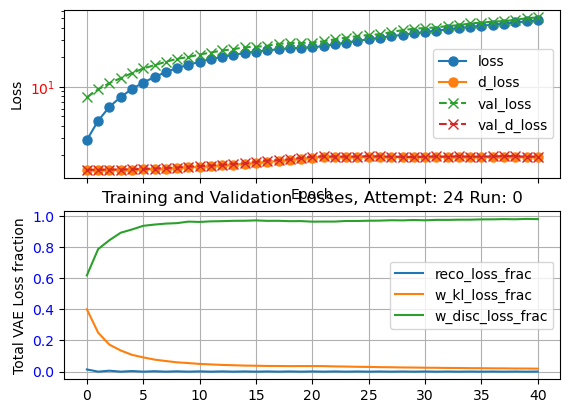

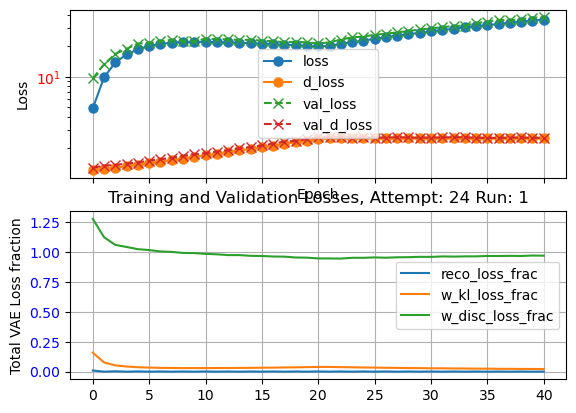

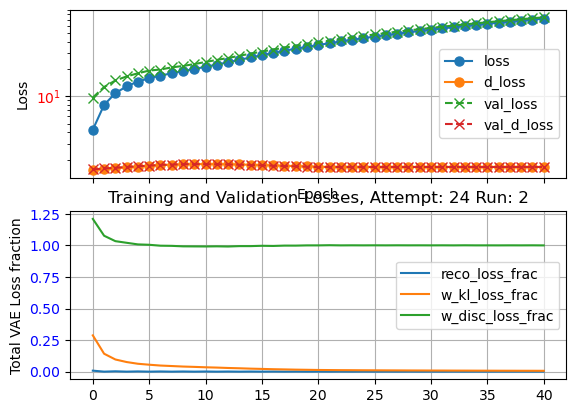

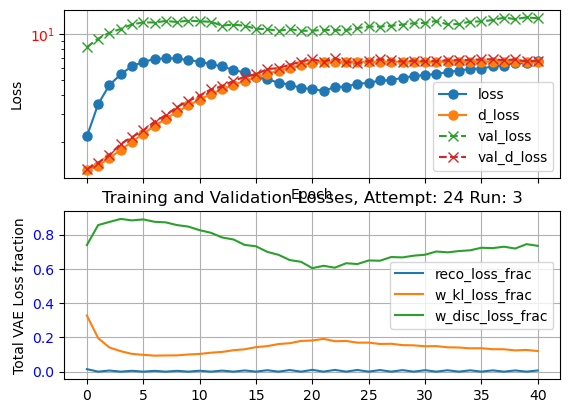

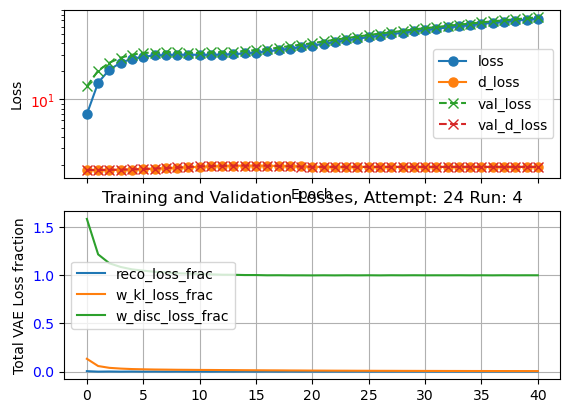

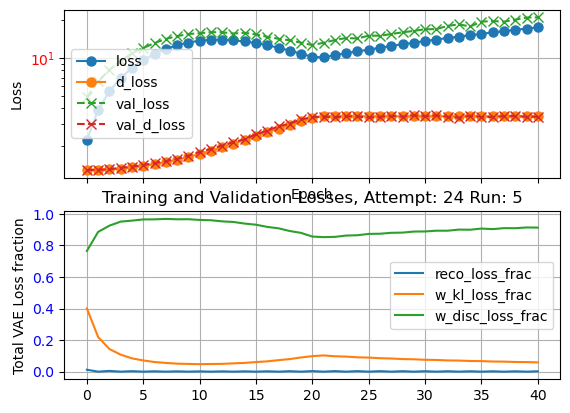

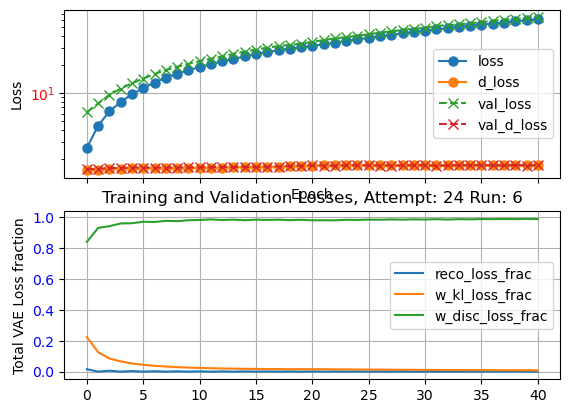

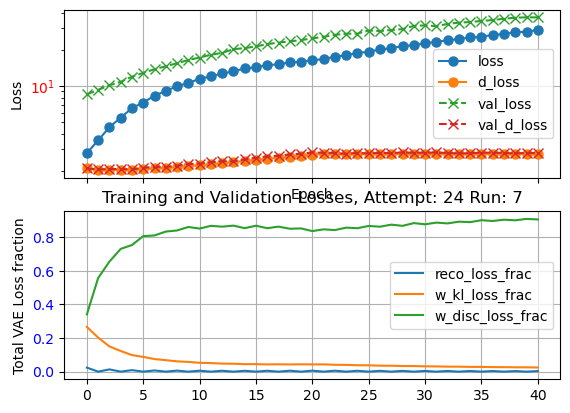

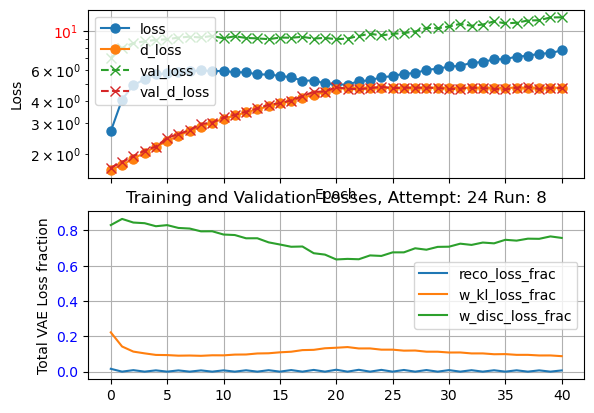

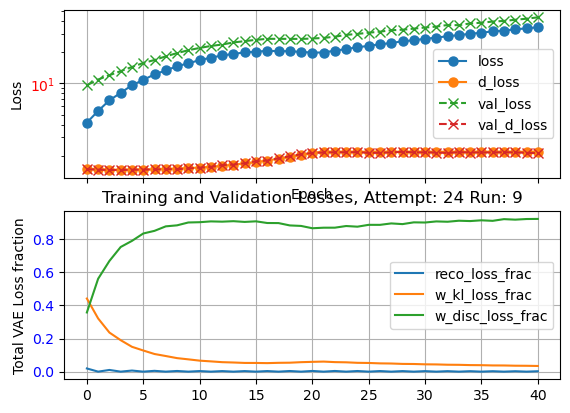

In [14]:
# History Keys
keys = [
        'loss'               # VAE total loss term.
        # ,'reco_loss'         # VAE loss term
        # ,'kl_loss'           # VAE Loss term
        # ,'disc_loss'         # VAE loss due to discriminator "failure to fool disc"
        # # ,'raw_loss'          # Reco_loss + kl_loss
        # ,'w_kl_loss'         # kl_loss * beta
        # ,'w_disc_loss'       # disc_loss * gamma
        ,'d_loss'
        # Validation version
        ,'val_loss'          
        # ,'val_reco_loss'
        # ,'val_kl_loss'
        # ,'val_disc_loss'
        # ,'val_raw_loss'
        # ,'val_w_kl_loss'
        # ,'val_w_disc_loss'
        ,'val_d_loss'
        # --
        # ,'beta'              # hyperparameter
        # ,'gamma'             # hyperparameter
        # ,'val_gamma'         # hyperparameter
        # ,'val_beta'          # hyperparameter
        # ,'lr'              # learning rate
        ]
# d_loss : discriminator loss
# loss : generator total loss
# raw_loss : reconstruction and kl_loss without beta weighting
for att_n in [24]: # plot all attempts. most recent is 18.
    att_path = SAVE_PATH + f"attempt{att_n}/"
    for i in range(10): # Currently only training 10 models at a time.
        save_path = att_path + f"n_{i}/"
        with open(save_path + 'training_history.pkl', 'rb') as f:
            history = pkl.load(f)
    
        
        # Plot training losses
        fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)

        # Calculate fractional contributions to total VAE loss
        loss = np.array(history['loss'])
        reco_loss = np.array(history['reco_loss'])
        beta = np.array(history['beta'])
        reco_loss_frac = (reco_loss * (1 - beta ))/loss

        w_kl_loss_frac = np.array(history['w_kl_loss'])/loss
        w_disc_loss_frac = np.array(history['w_disc_loss'])/loss
        ax2.plot(reco_loss_frac, label='reco_loss_frac')
        ax2.plot(w_kl_loss_frac, label='w_kl_loss_frac')
        ax2.plot(w_disc_loss_frac, label='w_disc_loss_frac')
        # ax2.set_ylim((0,1))
        ax2.set_ylabel('Total VAE Loss fraction')
        ax2.tick_params(axis='y', labelcolor='b')
        ax2.legend()
        ax2.grid()

        for key in keys:
            if key == 'lr' or history.get(key) == None:
                continue
            ax.plot(np.abs(history[key]), label=key, 
                     linestyle = "dashed" if key[0:3] == 'val' else "solid",
                     marker= "x" if key[0:3] == 'val' else "o",
                     markersize=6.5)
    
        # Customize the plot
        plt.title(f'Training and Validation Losses, Attempt: {att_n} Run: {i}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.tick_params(axis='y', labelcolor='r')
        ax.legend()
        ax.grid(True)
        ax.set_yscale('log')
    
        # Show the plot
        plt.show()

In [ ]:
# def calc_anomaly_scores(data, encoder: keras.Model, AD_metric, debug = True):
#     """
#     Parameters:
#     -----------
#     debug: Optional bool to skip latent space vectors that produce infinities.
#     Currently set to true as it seems only 2 specific cases are affected
#     """
#     dat_encoded = np.array(encoder.predict(data))[0] # This outputs shape (3, len(X_test), 3). Can't find satisfactory explanation for this behavior. (len(X_test), 3) makes sense. (3, len, 3) does not
#     # Kenny only uses the first list so we'll follow that convention.
#     # has shape (len(data), 3), where col 1 is z_mean, 2 is z_log_var and z. This is by design of encoder.
#     scores = np.zeros(len(data))
#     bad_model = False

#     for i in range(len(scores)):
#         z_mean, z_log_var = dat_encoded[i][0], dat_encoded[i][1]
#         score = AD_metric(z_mean, z_log_var)
#         if debug and (np.isinf(score) or np.isnan(score)):
#             print("Unstable model: inf encountered. Rejecting Model"
#                   + f"z_mean: {z_mean}\n"
#                   + f"z_log_var: {z_log_var}")
            
#             bad_model = True
#             break
#         else:
#             scores[i] = score

#     return (scores, bad_model)

In [ ]:
1 not in [2, 3]

In [ ]:
# Load data
data = load_preprocessed_snl()
# X_train = data['X_train']

##### Calculate Anomaly scores

In [ ]:
# def get_truth_and_scores(encoder, AD_metric, debug=True):
#     bg_score, bad_model = calc_anomaly_scores(X_test, encoder, AD_metric)
#     scores = []
#     truths = []
#     zeros = np.zeros(len(X_test))
#     signal_data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data]

#     # Generate Truth and score lists ready for ROC curve calculation
#     if not(bad_model):
#         for dat in signal_data:
#             truths.append(np.concatenate((zeros, np.ones(len(dat)))))

#             # Now we are actually testing for bad models as we calculate the
#             # anomaly scores for the other datasets
#             s, bad_model = calc_anomaly_scores(dat, encoder, AD_metric, debug=debug)
#             if bad_model: break
#             scores.append(np.concatenate((bg_score,s) ))

#     return (truths, scores, bad_model)

In [ ]:

# def plot_rocs(truths, scores, fig_title):
#     target_fpr = 1e-5
#     tpr_at_target = []
#     signal_names_tex = [ # latex version
#                     "Leptoquark"
#                     , "$A\\rightarrow 4\ell$"
#                     , "$h^{\pm}\\rightarrow\\tau \\nu$"
#                     , "$h^0\\rightarrow\\tau\\tau$"
#                     ]
#     signal_names_hum = [ # human readable
#                     "Leptoquark"
#                     ,"A to 4L"
#                     , "h to Tau Nu"
#                     , "h to Tau Tau"
#                     ]
#     fig, ax = plt.subplots()

#     thresholds_at_target = []
#     for truth, score, l in zip(truths, scores, signal_names_tex):
#         fpr, tpr, thresholds = roc_curve(truth, score)
#         auc = sk.roc_auc_score(truth, score)
#         ax.plot(fpr, tpr, label=l + f": {str(round(auc, 3))}") # plot roc curve


#         # Find tpr at fpr target
#         idx = np.argmin(np.abs(fpr - target_fpr))
#         tpr_at_target.append(tpr[idx])
#         thresholds_at_target.append(thresholds[idx])

#     ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--")
#     ax.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")

#     # Plot teaks
#     ax.loglog()
#     ax.legend()
#     ax.grid()
#     ax.set_xlabel("fpr")
#     ax.set_ylabel("tpr")
#     ax.set_title(fig_title) 
#     plt.show()

#     for i in range(len(signal_names_hum)):
#         print(signal_names_hum[i] + " TPR @ FPR 10e-5 (%): " + f"{tpr_at_target[i]*100:.2f}\n" + f"Target Threshold {thresholds_at_target[i]}")

#     return fig



In [ ]:
from pathlib import Path

TRAIN = False
INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
NUM_TRAIN = 10 # number of trained models
bad_models = []
SAVE_FIG = True
FILE_NAMES = ""
FIG_SAVE_PATH = SAVE_PATH + "plots/"
AD_metric = AD_score_CKL 

if TRAIN:
    for i in range(NUM_TRAIN):
        new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        new_disc = Qmake_discriminator(INPUT_SZ, 8, 2)
        new_VAE = VAE_GAN_Model(new_enc, new_dec, new_disc)
        save_path = SAVE_PATH + f"n_{i}/"

        new_VAE.load_weights(save_path)

        just_enc = new_VAE.get_layer("encoder") # We only need encoder output
        t, s, bad_model = get_truth_and_scores(just_enc, AD_metric)
        if bad_model:
            print(f"Unstable mode. Inf encountered. Model number {i} ")
            bad_models.append(i)
        else:
            f = plot_rocs(t, s, "ROC Curves using CKL as Anomaly Score. Model number: " + str(i))

            if SAVE_FIG:
                Path(FIG_SAVE_PATH+FILE_NAMES).mkdir(parents=True, exist_ok=True)
                f.savefig(FIG_SAVE_PATH + FILE_NAMES + f"_iter_{i}.png")


After inspecting the graphs a few notable models remain

In [ ]:
import pickle as pkl

SAVE_FIG = False
noteable_models_iter = [
                        # 0,
                        # 9,
                        # 14,
                        16 # best when considering DKL
                        # 17
                        ] # mins 88, 90, 89, 79 for AUC. 
# # 16 did the best AUC and I think also has higher TPR @ target FPR
AD_metric = AD_score_CKL

# for i in noteable_models_iter:

#     # Reload the Encoder ------
#     # for i in range(NUM_TRAIN):
#     new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
#     new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
#     new_VAE = NNmodel(new_enc, new_dec)
#     save_path = SAVE_PATH + f"n_{i}/"

#     new_VAE.load_weights(save_path)

#     just_enc = new_VAE.get_layer("encoder") # We only need encoder output
#     # ------

#     # Plot ROC curves and optionally save -----
#     t, s, bad_model = get_truth_and_scores(just_enc, AD_metric)

#     if bad_model:
#         print(f"Unstable mode. Inf encountered. Model number {i} ")
#         bad_models.append(i)
#         continue


#     f = plot_rocs(t, s, "ROC Curves using $D_{KL}$ as Anomaly Score. Model number: " + str(i))

#     if SAVE_FIG:
#         f.savefig(FIG_SAVE_PATH + FILE_NAMES + f"_iter_{i}.png")
#     # ------

#     # Reload history and plot loss curves ------
#     save_path = SAVE_PATH + f"n_{i}/"
#     with open(save_path + 'training_history.pkl', 'rb') as f:
#         history = pkl.load(f)
#     # Extract the loss values
#     total_loss = history['loss']
#     reco_loss = history['reconstruction_loss']
#     kl_loss = history['kl_loss']
#     val_total_loss = history['val_loss']
#     val_reco_loss = history['val_reconstruction_loss']
#     val_kl_loss = history['val_kl_loss']

#     # Create a new figure
#     plt.figure(figsize=(12, 8))

#     # Plot training losses
#     plt.plot(total_loss, label='Total Loss', color='blue')
#     plt.plot(reco_loss, label='Reconstruction Loss', color='green')
#     plt.plot(kl_loss, label='KL Loss', color='red')
#     plt.plot(history['beta'],label="beta")

#     # Plot validation losses
#     plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
#     plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
#     plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

#     # Customize the plot
#     plt.title(f'Training and Validation Losses Run: {i}')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.yscale("log")
#     plt.legend()
#     plt.grid(True)

#     # Show the plot
#     plt.show()
#     # -----

#     # Plot Anomaly score distribution -----


Anamoly Score Distribution

In [ ]:
# def calc_anomaly_dist(data, encoder: keras.Model, AD_metric):
#     """
#     Parameters:
#     -----------
#     debug: Optional bool to skip latent space vectors that produce infinities.
#     Currently set to true as it seems only 2 specific cases are affected
#     """
#     dat_encoded = np.array(encoder.predict(data))[0] # This outputs shape (3, len(X_test), 3). Can't find satisfactory explanation for this behavior. (len(X_test), 3) makes sense. (3, len, 3) does not
#     # Kenny only uses the first list so we'll follow that convention.
#     # has shape (len(data), 3), where col 1 is z_mean, 2 is z_log_var and z. This is by design of encoder.
#     scores = np.zeros(len(data))
#     for i in range(len(scores)):
#         z_mean, z_log_var = dat_encoded[i][0], dat_encoded[i][1]
#         scores[i] = AD_metric(z_mean, z_log_var)
    
#     return scores

In [ ]:
new_enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
new_disc = Qmake_discriminator(INPUT_SZ, 8, 2)
new_VAE = VAE_GAN_Model(new_enc, new_dec, new_disc)
save_path = SAVE_PATH + f"n_{5}/" # 5 for CKL VAE-GAN

new_VAE.load_weights(save_path)

just_enc = new_VAE.get_layer("encoder") # We only need encoder output


In [ ]:

# data = [leptoquark_data, Ato4l_data, hChToTauNu_data, hToTauTau_data
#                , X_train
#                , X_test
#                ] # Already defined.
data_names_tex = [ # latex version
                "Leptoquark"
                , "$A\\rightarrow 4\ell$"
                , "$h^{\pm}\\rightarrow\\tau \\nu$"
                , "$h^0\\rightarrow\\tau\\tau$"
                , "Training Set (BG)" # Background
                , "Test Set (BG)" # Background
                ]

anomaly_scores = []
for data in data:
    s = calc_anomaly_dist(data, just_enc, AD_score_CKL)
    anomaly_scores.append(s)


In [ ]:
# plot setting for CKL
bin_n = 125
xlims = (0, 40)
ylims = (0, 0.03)
bins  = np.linspace(xlims[0], xlims[1], bin_n)
xlabel = "Clipped KL"


# # Investigating around the threshold at 161
# ckl_roc_threshold = 161.84
# bin_n = 10
# l_margin = 10 
# r_margin = 300

# xlims = ( ckl_roc_threshold - l_margin , ckl_roc_threshold + r_margin)
# ylims = (0, 0.01)
# bins  = np.linspace(xlims[0], xlims[1], bin_n)
# xlabel = "Clipped KL"

# Plot settings for KL
# bin_n = 125
# xlims = (0, 40)
# ylims = (0, 0.0125)
# bins  = np.linspace(0, xlims[1], bin_n)
# xlabel = "KL Divergence"

for i in range(len(data_names_tex)):
    dat = anomaly_scores[i]
    # print(bin_n)
    plt.hist(dat
             , bins = bins
             , label=data_names_tex[i] # + " " + str(bin_n)
             , histtype = "step"
             , density=True
             )
plt.legend(loc="upper right")
# plt.vlines(ckl_roc_threshold, 0, 1)
# plt.loglog()
# plt.semilogy()
# plt.semilogx()
plt.xlabel(xlabel)
plt.ylabel("Density")
plt.grid()
plt.ylim(ylims)
plt.xlim(xlims)
plt.title("Anomaly Score Distribution Across Datasets")